In [1]:
import os
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import scipy
from moss import glm
import seaborn as sns
import matplotlib.pyplot as plt
import nibabel as nib
%matplotlib inline

In [97]:
start_offset = 12 #saturation time
tr = 2#1.5
root_decision_duration = 2
choice_decision_duration = .75
feedback_duration = 1

n_best_models = 20 #number of models to keep
nmodels = 5000 #number of models to make

#iti params
mean_iti = 4.5
min_iti = 2 
max_iti = 14

#isi params (between choice and response cue)
mean_isi = 4.5
min_isi = 2
max_isi = 14



In [123]:
ntrials = 25

In [124]:
def get_isi(mean_isi, min_isi, max_isi, ntrials):
    isis = np.random.poisson(lam = mean_isi, size=ntrials*5)
    isis = [x for x in isis if x <= max_isi and x >= min_isi]
    return np.array(isis[0:ntrials])

In [131]:
isi1 = get_isi(mean_isi, min_isi, max_isi, ntrials)
isi2 = get_isi(mean_isi, min_isi, max_isi, ntrials)
iti = get_isi(mean_iti,min_iti, max_iti, ntrials)
np.mean(isi1),np.mean(isi2),np.mean(iti),np.mean([isi1]+[isi2]+[iti])

(4.4, 4.52, 4.52, 4.48)

In [132]:
first_isi = iti
itty = isi1

In [133]:
isi1 = first_isi
iti = itty

In [134]:
np.mean(isi1),np.mean(isi2),np.mean(iti),np.mean([isi1]+[isi2]+[iti])

(4.52, 4.52, 4.4, 4.48)

In [135]:
def get_efficiency(contrast = None):

    
    np.random.shuffle(isi1)
    np.random.shuffle(isi2)
    np.random.shuffle(iti)
    
    timing = pd.DataFrame({'isi1':isi1, 'isi2':isi2, 'iti':iti})
    
    root_times = []
    choice_times = []
    feedback_times = []
    for i in range(ntrials):
        if i == 0:
            root_times.append(start_offset)
        else:
            root_times.append(feedback_times[-1] + feedback_duration + iti[i-1])
            
        choice_times.append(root_times[-1] + root_decision_duration + isi1[i])
        feedback_times.append(choice_times[-1] + choice_decision_duration + isi2[i])

    
    #build design
    design = pd.DataFrame({'condition':['root']*ntrials + ['choice']*ntrials + ['feedback']*ntrials,
                      'onset': root_times + choice_times + feedback_times,
                      'duration': [root_decision_duration]*ntrials + [choice_decision_duration]*ntrials + [feedback_duration]*ntrials,
                     })
 
    #convolve 
    hrf = glm.GammaDifferenceHRF()
    ntp = int((feedback_times[-1] + 12)/tr)
    model = glm.DesignMatrix(design = design, tr = tr, ntp = ntp, hrf_model = hrf, hpf_cutoff = 128)
    X = model.design_matrix.values

    #get efficiency
    XX = np.linalg.inv((X.T).dot(X))
#     if contrast is None:
#         eff = 1 / np.trace(XX)
#     else:
# #         contrast = np.array(model.design_matrix.columns == contrast).astype(int)
#         c = contrast.dot(XX).dot(contrast.T)
#         eff = 1 / c
#     eff = 1 / np.trace(XX)
    contrast = np.array([[1, 0, 0], #maximize individual contrast
             [0, 1, 0],
             [0, 0, 1]])
    c = np.trace(contrast.dot(XX).dot(contrast.T))
    eff = 1.0/c
        
    return design,eff,model, timing


In [136]:
design,eff,model,timing = get_efficiency(contrast = None)
eff, design['onset'].values[-1]/60

(0.211657798181293, 7.295833333333333)

In [137]:
design['onset'].values[-1]/60

7.295833333333333

In [138]:
#enumerate lots of models
model_list = []
for i in range(nmodels):
    model_list.append(get_efficiency())
    
    if i%100 == 0:
        print(i)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900


In [139]:
model_list.sort(key=lambda x: x[1],reverse=True) #sort

(array([  10.,   26.,  117.,  398.,  961., 1435., 1300.,  632.,  111.,
          10.]),
 array([0.18647662, 0.19264949, 0.19882237, 0.20499524, 0.21116812,
        0.21734099, 0.22351387, 0.22968675, 0.23585962, 0.2420325 ,
        0.24820537]),
 <a list of 10 Patch objects>)

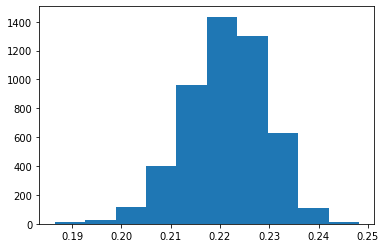

In [140]:
#plot efficiencies
effs = [x[1] for x in model_list]
plt.hist(effs)

In [141]:
# #save top models
# model_clean = []
# for model, d, d2 in model_list:
    
#     cond = [x for x in model['condition'] if x != 'choice']
#     if cond[0] != 'neg':
#         model_clean.append(model)


In [142]:
#save top models
for i, (design,eff,model, timing) in enumerate(model_list):
    
    if i > n_best_models:
        break
    
    out_f = os.path.abspath('../fmri_task/timing/12_runs/run' + str(i) + '.csv')
    design.to_csv(out_f,index = False)
    
    out_f = os.path.abspath('../fmri_task/timing/12_runs/run' + str(i) + '_timing.csv')
    timing.to_csv(out_f,index = False)
    print(eff)

0.2482053733692646
0.2461131653183302
0.2449587113070049
0.2438707003203922
0.24347821709151576
0.24308534648683583
0.24262420848308802
0.24257110590249206
0.24236918600848842
0.24214499217039967
0.24200133850627706
0.2419819913569413
0.24183342149774675
0.2417969652385085
0.24170010531109637
0.2415411524807605
0.24153694655501712
0.24152519761182764
0.241467535342529
0.2412800993503551
0.2406818564898011


In [109]:
536/2

268.0

In [110]:
536/60

8.933333333333334